In [1]:
import numpy as np
import os
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# SVM Third attempt

Using the localisation model (Wierstorf 2014), HRTF comparisons have been made. This should enhance the SVM-RFE method due to more data within good matches.

Due to nan values from computing the error between 90 and 90, the narrowed range of 60 to 60 was used, and errors were only computed at the locations provided in the HRTFs to minimse the effects of interpolation on predicting the matches.

Self HRTF errors in this range are on the order of 0.3 . As a result, there are very few HRTFs that are less than the own HRTF (TODO1)

To asses new thresholds, a histogram of all errors will be generated to see the spread and determine thresholds beyond that of the self HRTF error.

This also takes into account the exclusion of theta2 for both ears

In [2]:
s = 4
sub = np.loadtxt("C:\\Users\\simon\\OneDrive\\Documents\\Senior Thesis\\Code\\Datasets\\HUTUBS\\simu\\Err_rows_6060\\{0}.txt".format(s))
mks = np.ma.masked_invalid(sub)


In [3]:
# Importing txt files to build vectors

match_class = np.zeros(93**2)

for s in range(2,96):
    if s < 88:
        sub = np.loadtxt("C:\\Users\\simon\\OneDrive\\Documents\\Senior Thesis\\Code\\Datasets\\HUTUBS\\simu\\Err_rows_6060\\{0}.txt".format(s))
        
        for t in range(0,93):
            
            if np.isnan(sub[t]):
                sub[t] = 0
                       
            #print(((s-2)*93) + t)
            
            match_class[((s-2)*93) + t] = sub[t]
    if s > 88:
        sub = np.loadtxt("C:\\Users\\simon\\OneDrive\\Documents\\Senior Thesis\\Code\\Datasets\\HUTUBS\\simu\\Err_rows_6060\\{0}.txt".format(s))
        for t in range(0,93):
            
            if np.isnan(sub[t]):
                sub[t] = 0
                       
            match_class[((s-3)*93) + t] = sub[t]
            


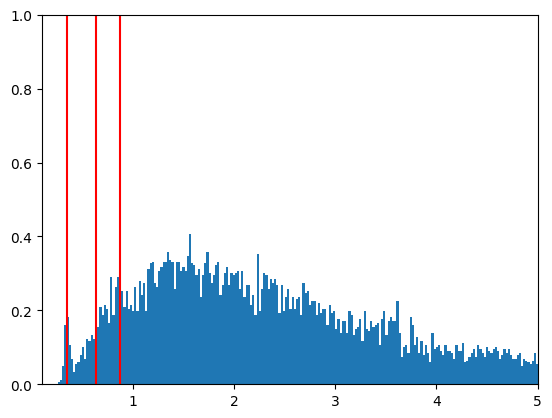

In [4]:
plt.hist(match_class, bins=800, density=True)
plt.xlim([0.1, 5])
plt.ylim(0, 1)
plt.vlines(0.87, 0, 150, colors='r')
plt.vlines(0.64, 0, 150, colors='r')
plt.vlines(0.35, 0, 150, colors='r')
plt.show()


In this histogram, we identify a peak around 0.35, which corresponds to the typical self HRTF error. Another peak can be identified at 0.64, and 0.87. As a result, the thresholds aim to capture these peaks to classify HRTF matches. However, it is worth mentioning this excludes a significant portion of the data compared to the previous iteration

In [5]:
s = 7
#sub = np.loadtxt("C:\\Users\\simon\\OneDrive\\Documents\\Senior Thesis\\Code\\Datasets\\HUTUBS\\simu\\Err_rows\\{0}.txt".format(s))
#sub
#match_class[(s*93):(s+1)*93] = sub
print(match_class[(s*93):(s+1)*93][s])

0.334234772664391


In [6]:
# Classifying errors
lasses1 = np.zeros_like(match_class)
lasses2 = np.zeros_like(match_class)
lasses3 = np.zeros_like(match_class)

thr1 = 0.37
thr2 = 0.66
thr3 = 0.89

for s in range(93):
    arr = match_class[(s*93):(s+1)*93]
    mx = np.ma.masked_array(arr, mask=arr==0)
    
    #print(submin)
    arr1 = np.zeros(93)
    arr2 = np.zeros(93)
    arr3 = np.zeros(93)

    # Iterate through all error values
    for i in range(len(arr)):
        
        # Strictest threshold
        if arr[i] <= (thr1):
            arr1[i] = 1
        
        if arr[i] <= (thr2):
            arr2[i] = 1

        if arr[i] <= (thr3):
            arr3[i] = 1

    # Reassign
    lasses1[(s*93):(s+1)*93] = arr1
    lasses2[(s*93):(s+1)*93] = arr2
    lasses3[(s*93):(s+1)*93] = arr3

print(np.count_nonzero(lasses3))


793


Based on the current data, the three classifiers lead to 82/8649 matches, 331/8649 matches, and 793/8649 matches. SVM-RFE will be performed with these classifiers

Some entries (18,79,92) lack anthropometric data so they are being removed from the HRTF dataset. This corresponds to rows 17, 78 and 91.

 In addition to this, subjects 1, 96, and 88 must also be removed (rows 0,95,87) from the anthropometric dataset due to their exclusion from the HRTF dataset.

The match data will be reprocessed using this information


In [7]:
# Function to remove bad subjects due to lacking anthropometric data
# Takes a subject num, checks if it is valid for inclusion
# If yes, remove the values with excluded subject HRTFs
# Fill in next section of vector by returning rem_count

def rem_sub(ind, ex_sub, out_vec, rem_counta):
    
    if ind not in ex_sub:
        sub = np.loadtxt("C:\\Users\\simon\\OneDrive\\Documents\\Senior Thesis\\Code\\Datasets\\HUTUBS\\simu\\Err_rows_6060\\{0}.txt".format(ind))
        rem_countb = 0
        
        for t in range(0,93):
            
            # Ignoring tests with excluded HRTFs
            if t not in ex_sub:
                if np.isnan(sub[t]):
                    sub[t] = 0

                out_vec[((ind - (2 + rem_counta))*90) + (t - rem_countb)] = sub[t]
            
            elif t in ex_sub:
                rem_countb += 1

    elif ind in ex_sub:
        rem_counta += 1     

    return out_vec, rem_counta    
            

It would most likely be simpler to create a square array, remove the unwanted rows and columns, then flatten the output

In [8]:
# Modifying HRTF matches dataset to remove subjects 18,79,92
# These are rows 16, 77, 89
# These appear as the 16th, 77th and 89th test (indexes) for each subject


# Importing txt files to build class vector
match_class = np.zeros((93,93))

for s in range(2,96):
    if s < 88:
        sub = np.loadtxt("C:\\Users\\simon\\OneDrive\\Documents\\Senior Thesis\\Code\\Datasets\\HUTUBS\\simu\\Err_rows_6060\\{0}.txt".format(s))
        match_class[(s-2)] = sub
    if s > 88:
        sub = np.loadtxt("C:\\Users\\simon\\OneDrive\\Documents\\Senior Thesis\\Code\\Datasets\\HUTUBS\\simu\\Err_rows_6060\\{0}.txt".format(s))
        match_class[(s-3)] = sub

# Delete columns then rows
match_class1 = np.delete(match_class, [16,77,89], 1)    
match_class2 = np.delete(match_class1, [16, 77, 89], 0)

np.shape(match_class2)


(90, 90)

In [9]:
np.argwhere(np.isnan(match_class1))

array([[79, 81]], dtype=int64)

In [10]:
# Anthro data
csv_path = "C:\\Users\\simon\\OneDrive\\Documents\\Senior Thesis\\Code\\Datasets\\HUTUBS\\AntrhopometricMeasures.csv"
anthro = np.loadtxt(csv_path, delimiter=',', skiprows=1)
anthred = np.delete(anthro, [0], axis=1)
anthred2 = np.delete(anthred, [0,17,78,87,91,95], axis=0)
np.shape(anthred2)

(90, 35)

The HRTF data is now 90 x 90, anthro data is now 90x37. This makes both suitable for SVM-RFE

In [11]:
# Classifying errors
lasses1 = np.zeros_like(match_class2)
lasses2 = np.zeros_like(match_class2)
lasses3 = np.zeros_like(match_class2)

thr1 = 0.37
thr2 = 0.66
thr3 = 0.89


for s in range(90):
    #std = np.nanstd(arr)
    #submin = arr[s]
    #print(arr)

    # Strictest case
    lasses1[s] = match_class2[s].copy()
    lasses1[s][lasses1[s] > thr1] = 0
    lasses1[s][lasses1[s] > 0] = 1
    lasses1[s][np.isnan(lasses1[s])] = 0
    #print(lasses1[s])
    
    # Second strictest
    lasses2[s] = match_class2[s].copy()
    lasses2[s][lasses2[s] > thr2] = 0
    lasses2[s][lasses2[s] > 0] = 1
    lasses2[s][np.isnan(lasses2[s])] = 0
    #print(lasses2[s])

    # Third strictest
    lasses3[s] = match_class2[s].copy()
    lasses3[s][lasses3[s] > thr3] = 0
    lasses3[s][lasses3[s] > 0] = 1
    lasses3[s][np.isnan(lasses3[s])] = 0
    #print(lasses3[s])
    
    
    


In [12]:
print(np.count_nonzero(lasses1),np.count_nonzero(lasses2),np.count_nonzero(lasses3), np.shape(lasses1))

78 318 755 (90, 90)


78/8100, 318/8100, 755/8100

In [13]:
# Flattening HRTF data
f1 = lasses1.flatten()
f2 = lasses2.flatten()
f3 = lasses3.flatten()




Taken from the paper

The values of all morphologic parameters for all subjects were divided by the data of each subject. With this normalization, the values represented the percentage of a morphological parameter of a subject compared to another.

This requires summing each row and dividing each feature by the sum for each subject

To classify, all subjects, their HRTFs and features will be paired. For the input data (anthro features), each pairing will have their percentages subtracted.

This creates a 93^2 by 35 matrix. Each row in the matrix is Xi - Xj, where Xi refers to the first subject and Xj refers to the second

In [14]:
# Normalisation
anthnorm = np.zeros_like(anthred2)
for i in range(0,np.shape(anthred2)[0]):
    anthnorm[i] = anthred2[i] / np.sum(anthred2[i])

np.shape(anthnorm)


inp = np.zeros((90**2, 35))

for i in range(0, 90):
    for j in range(0, 90):
        inp[(90*i)+j] = anthnorm[i] - anthnorm[j]

np.shape(inp)

(8100, 35)

Building the SVM

In [15]:
clf1 = svm.LinearSVC(C=10)
clf1.fit(inp, f1)
selector1 = RFE(clf1, n_features_to_select=14, step=1)
selector1 = selector1.fit(inp, f1)
feats1 = np.where(selector1.ranking_ == 1)
feats1


c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

(array([ 0,  1,  2,  3,  4,  5,  6, 15, 16, 21, 28, 29, 32, 34],
       dtype=int64),)

Now we have constructed a strict model, we will try to perform RFE to select the 14 most important features. This is a higher value than used in the referenced paper

In [16]:
clf2 = svm.LinearSVC(C=10)
clf2.fit(inp, f2)
selector2 = RFE(clf2, n_features_to_select=14, step=1)
selector2 = selector2.fit(inp, f2)
feats2 = np.where(selector2.ranking_ == 1)
feats2


c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

(array([ 0,  1,  2,  5,  6,  7,  8, 11, 12, 15, 20, 23, 24, 34],
       dtype=int64),)

In [17]:
clf3 = svm.LinearSVC(C=10)
clf3.fit(inp, f3)
selector3 = RFE(clf3, n_features_to_select=14, step=1)
selector3 = selector3.fit(inp, f3)
feats3 = np.where(selector3.ranking_ == 1)
feats3


c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

(array([ 1,  2,  5,  7,  8,  9, 10, 11, 13, 16, 23, 28, 29, 34],
       dtype=int64),)

To make these features easier to identify, feature values will be translated into feature names

In [18]:
import csv
csv_path = "C:\\Users\\simon\\OneDrive\\Documents\\Senior Thesis\\Code\\Datasets\\HUTUBS\\AntrhopometricMeasures.csv"
file = open(csv_path)
type(file)
csvreader = csv.reader(file)
header = []
header = next(csvreader)


In [19]:
def feat_trans(feats, header):
    feat_list = []
    for i in feats:
        feat_list.append(header[i+1])
    return feat_list

In [20]:
feat_trans(feats1[0], header)

['x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'L_d3',
 'L_d4',
 'L_d9',
 'R_d5',
 'R_d6',
 'R_d9',
 'R_theta1']

In [21]:
# Checking optima features with 5 cross fold validation
min_features_to_select = 5  # Minimum number of features to consider
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf1,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(inp, f1)

print(f"Optimal number of features: {rfecv.n_features_}")

c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

Optimal number of features: 5


c:\Users\simon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


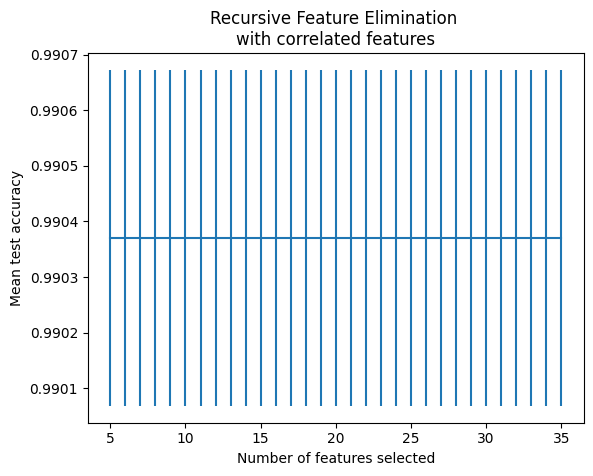

In [22]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [23]:
import numpy as np
from operator import itemgetter

xx = np.array([1,2,3,4,5,6,7,8,9,12,14, 16, 17])

itemgetter(0,1,4,6,7,9,10,12)(xx)

(1, 2, 5, 7, 8, 12, 14, 17)